In [1]:
# importing required libaries

# for handling dataframe operations
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

# for machine learning model building
from sklearn import linear_model
from sklearn.svm import SVC


# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# to get the status of jobs in loop
from tqdm import tqdm

# to filter-out all the warnings given by python modules
import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading the data from csv and looking first 5 rows
data = pd.read_csv("NASA.csv")
data.head(5)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


- by quickly observing we can find this things from data:

    - We can drop features id, name, orbiting_body, sentry_object. Since they are almost unique values, so it can't be useful for us to classify data points.
    - Hazardous column consists values either true or false (string), we can convert them to 0 or 1.

In [3]:
hazardous_encoder = preprocessing.LabelEncoder() # initializing label encoder object 
data['hazardous'] = hazardous_encoder.fit_transform(data.hazardous) # transforming false to 0 and true to 1 in hazardous column
data.drop(['id', 'name', 'orbiting_body', 'sentry_object'], axis=1, inplace=True) # dropping the columns consists of unique values
data.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1


### Checking for missing data

In [4]:
data.isnull().sum(axis = 0)

est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
dtype: int64

 - This indicating we don't have any missing data in our features

### Glimpse of feature stastics:

In [5]:
data.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
count,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000,90836.000000
mean,0.127432,0.284947,48066.918918,3.706655e+07,23.527103,0.097318
std,0.298511,0.667491,25293.296961,2.235204e+07,2.894086,0.296392
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000,0.000000
25%,0.019256,0.043057,28619.020645,1.721082e+07,21.340000,0.000000
50%,0.048368,0.108153,44190.117890,3.784658e+07,23.700000,0.000000
75%,0.143402,0.320656,62923.604633,5.654900e+07,25.700000,0.000000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000,1.000000


### Exploratory Data Analysis:
 - Here we will check the distributions of each column and we will remove potential outliers in our dataset

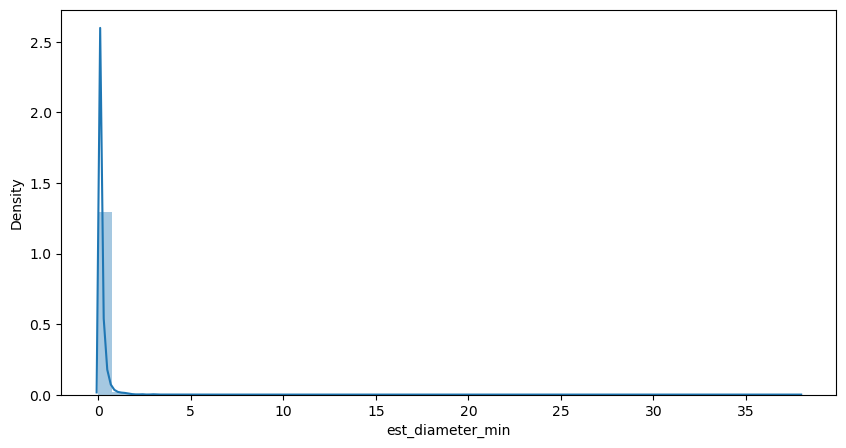

In [6]:
# est_diameter_min:
plt.rcParams['figure.figsize'] = (10, 5)
sns.distplot(data['est_diameter_min'])
plt.show()

 - This distribution of est_diameter is right skewed, so there is a high chance of potential outliers. 
 - By using Z-score concept, we can drop values which are lesser than mu - 3*sigma and higher than mu + 3*sigma

In [7]:
lower_bound = data['est_diameter_min'].quantile(0.01) 
upper_bound  = data['est_diameter_min'].quantile(0.99)

data = data[(data["est_diameter_min"] < upper_bound) & (data["est_diameter_min"] > lower_bound)]
data.shape

(89018, 6)

In [8]:
# We are gonna apply same technique on every numeric column in our data:
remaining_columns = ["est_diameter_max", "relative_velocity", "miss_distance", "absolute_magnitude"]
for i in remaining_columns:
    lower_bound = data[i].quantile(0.01) 
    upper_bound  = data[i].quantile(0.99)
    data = data[(data[i] < upper_bound) & (data[i] > lower_bound)]

 <b> Let's Analyze Target Feature "hazardous" </b>

In [9]:
# check the count of each category in target feature:
data.hazardous.value_counts()

hazardous
0    74119
1     7792
Name: count, dtype: int64

In [10]:
print("Percentage of non hazardous data points: ", data.hazardous.value_counts()[0]/data.shape[0])
print("Percentage of hazardous data points: ", data.hazardous.value_counts()[1]/data.shape[0])

Percentage of non hazardous data points:  0.904872361465493
Percentage of hazardous data points:  0.09512763853450697


 - This is clear evident of unbalanced data. 
 - Why?
  - In the given data 90% of the data points are belong to class 0 (non hazardous) and only 10% of data points are belongs to class 1 (hazardous)
  - We can handle this situation by giving more weight to minority class, which is hazardous

### Splitting the data:

In [11]:
# Here are we are using 80% of data for training and 20% of data as testing with random state = 4 (to reproduce the same results)
x, y = data.iloc[:, 0:-1], data.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

### Scaling the features:

In [12]:
# we will check for both normalization and standardization
# In standardization data will be scaled between [-1, 1]

# standardization
x_train_stand, x_test_stand = x_train.values, x_test.values # returns a numpy array
standard_scaler = preprocessing.StandardScaler() # initializing the StandardScaler class object
x_train_stand = standard_scaler.fit_transform(x_train_stand)
x_test_stand = standard_scaler.transform(x_test_stand)

# Normalization
x_train_norm, x_test_norm = x_train.values, x_test.values # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler() # initializing the min max scaler class object
x_train_norm = min_max_scaler.fit_transform(x_train_norm)
x_test_norm = min_max_scaler.transform(x_test_norm)

### Bulding models:

#### 1. Logistic Regrssion

#### Hyperparameter tuning:

100%|██████████| 10/10 [00:00<00:00, 14.18it/s]



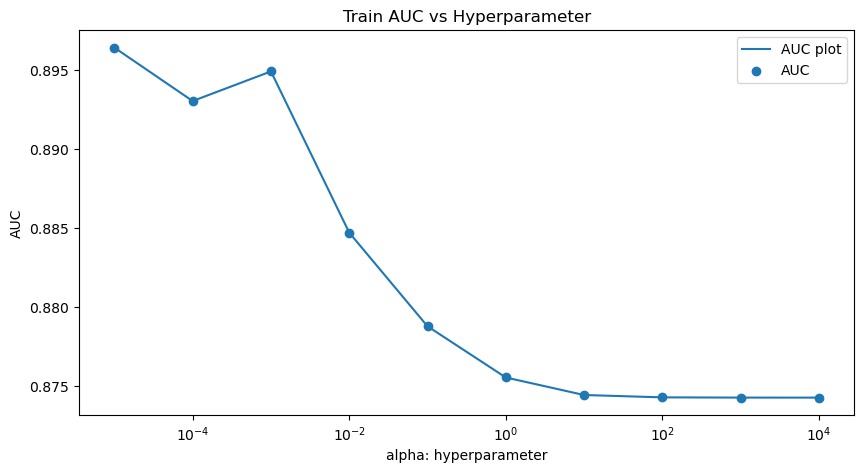

In [14]:
# expermiment 1: Building Logistic Regression model
 # 1.1 using the features which are normalized
 # 1.2 using the fatures which are standardized

hyper_parameter = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1, 10, 100, 1000, 10000]
train_auc_normalized_data, train_auc_stdized_data = [], []
for i in tqdm(hyper_parameter):
    clf = linear_model.SGDClassifier(loss="log_loss", 
                                     penalty="l2", 
                                     alpha=i,
                                     n_jobs=-1,
                                     class_weight='balanced', random_state=4)
    clf.fit(x_train_stand, y_train)
    y_train_pred = clf.predict_proba(x_train_stand)[:,1]    
    train_auc_stdized_data.append(roc_auc_score(y_train, y_train_pred))
    
plt.semilogx(hyper_parameter, train_auc_stdized_data, label='AUC plot')
plt.scatter(hyper_parameter, train_auc_stdized_data, label='AUC')

plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Train AUC vs Hyperparameter")

plt.legend()
plt.show()
plt.grid='True'

 - We are getting good results with Standardized data, with alpha = 10^-3

In [15]:
# Building the model with the best alpha value:

clf = linear_model.SGDClassifier(loss="log_loss", 
                                 penalty="l2", 
                                 alpha=10**-3,
                                 n_jobs=-1,
                                 class_weight='balanced', random_state=4)
clf = clf.fit(x_train_stand, y_train)
y_train_pred = clf.predict(x_train_stand) 
y_test_pred = clf.predict(x_test_stand)

print("Accuray for training data is: {0} and for test data is: {1}".format(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)))
print("\n")
print("Precision for training data is: {0} and for test data is: {1}".format(precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)))
print("\n")
print("Recall for training data is: {0} and for test data is: {1}".format(recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)))
print("\n")
print("F1 Score for training data is: {0} and for test data is: {1}".format(f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)))
print("\n")
print("AUC Score for training data is: {0} and for test data is: {1}".format(roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)))

Accuray for training data is: 0.785236845318032 and for test data is: 0.7816028810352195


Precision for training data is: 0.3044785091674181 and for test data is: 0.2950688760231583


Recall for training data is: 0.9698420296792724 and for test data is: 0.9691803278688524


F1 Score for training data is: 0.4634564794692897 and for test data is: 0.4524028160391797


AUC Score for training data is: 0.8677782059096484 and for test data is: 0.8657652884464736


In [17]:
result = pd.DataFrame(data=np.array([y_test, y_test_pred]).T, columns=["original", "predicted"])
result.to_csv("logistic_regression_results.csv", index=False)

####  2. SVM

In [18]:
model = SVC(class_weight='balanced')
param_grid = {'C':[1, 10, 100], 'kernel':['rbf', 'poly']}
grid = GridSearchCV(model, param_grid, cv=3, return_train_score=True, verbose=5)
grid.fit(x_train_norm,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END C=1, kernel=rbf;, score=(train=0.773, test=0.774) total time=  20.4s
[CV 2/3] END C=1, kernel=rbf;, score=(train=0.776, test=0.775) total time=  20.2s
[CV 3/3] END C=1, kernel=rbf;, score=(train=0.773, test=0.773) total time=  20.1s
[CV 1/3] END C=1, kernel=poly;, score=(train=0.772, test=0.773) total time=  13.3s
[CV 2/3] END C=1, kernel=poly;, score=(train=0.774, test=0.773) total time=  13.0s
[CV 3/3] END C=1, kernel=poly;, score=(train=0.771, test=0.771) total time=  13.0s
[CV 1/3] END C=10, kernel=rbf;, score=(train=0.780, test=0.780) total time=  20.1s
[CV 2/3] END C=10, kernel=rbf;, score=(train=0.781, test=0.779) total time=  20.0s
[CV 3/3] END C=10, kernel=rbf;, score=(train=0.779, test=0.779) total time=  20.0s
[CV 1/3] END C=10, kernel=poly;, score=(train=0.773, test=0.774) total time=  19.8s
[CV 2/3] END C=10, kernel=poly;, score=(train=0.775, test=0.774) total time=  20.8s
[CV 3/3] END C=10, kernel=po

GridSearchCV(cv=3, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [1, 10, 100], 'kernel': ['rbf', 'poly']},
             return_train_score=True, verbose=5)

In [19]:
print("The best accuracy is: {0} and the best model parameters are: {1}".format(grid.best_score_, grid.best_params_))

The best accuracy is: 0.7843364714112329 and the best model parameters are: {'C': 100, 'kernel': 'rbf'}


In [20]:
clf = SVC(C=100, kernel='rbf', class_weight='balanced')
clf = clf.fit(x_train_norm, y_train)
y_train_pred = clf.predict(x_train_norm) 
y_test_pred = clf.predict(x_test_norm)

print("Accuray for training data is: {0} and for test data is: {1}".format(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)))
print("\n")
print("Precision for training data is: {0} and for test data is: {1}".format(precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)))
print("\n")
print("Recall for training data is: {0} and for test data is: {1}".format(recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)))
print("\n")
print("F1 Score for training data is: {0} and for test data is: {1}".format(f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)))
print("\n")
print("AUC Score for training data is: {0} and for test data is: {1}".format(roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)))

Accuray for training data is: 0.7848400683677207 and for test data is: 0.7806872978087042


Precision for training data is: 0.3070935960591133 and for test data is: 0.29709576138147564


Recall for training data is: 0.9947343226424127 and for test data is: 0.9927868852459016


F1 Score for training data is: 0.46930402378891106 and for test data is: 0.45733272919498563


AUC Score for training data is: 0.8786887724988779 and for test data is: 0.8758523199954101


In [21]:
result = pd.DataFrame(data=np.array([y_test, y_test_pred]).T, columns=["original", "predicted"])
result.to_csv("svm_results_without_pca.csv", index=False)

### Dimensionality reduction using PCA

In [22]:
pca = PCA(n_components=2) # initializing the pca class object with 2 components
pca.fit(x_train_stand)
x_train_dim_reduced = pca.transform(x_train_stand) # dimenssions reduced train data
x_test_dim_reduced = pca.transform(x_test_stand) # dimenssions reduced test data

#### Let's build new model on dimenssionality reduced data:

In [23]:
model = SVC(class_weight='balanced')
param_grid = {'C':[1, 10, 100], 'kernel':['rbf', 'poly']}
grid = GridSearchCV(model, param_grid, cv=3, return_train_score=True, verbose=5)
grid.fit(x_train_dim_reduced,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END C=1, kernel=rbf;, score=(train=0.775, test=0.777) total time=  17.2s
[CV 1/3] END C=1, kernel=rbf;, score=(train=0.775, test=0.777) total time=  17.2s
[CV 2/3] END C=1, kernel=rbf;, score=(train=0.777, test=0.776) total time=  17.0s
[CV 2/3] END C=1, kernel=rbf;, score=(train=0.777, test=0.776) total time=  17.0s
[CV 3/3] END C=1, kernel=rbf;, score=(train=0.775, test=0.774) total time=  17.2s
[CV 3/3] END C=1, kernel=rbf;, score=(train=0.775, test=0.774) total time=  17.2s
[CV 1/3] END C=1, kernel=poly;, score=(train=0.835, test=0.839) total time=  25.6s
[CV 1/3] END C=1, kernel=poly;, score=(train=0.835, test=0.839) total time=  25.6s
[CV 2/3] END C=1, kernel=poly;, score=(train=0.838, test=0.835) total time=  26.2s
[CV 2/3] END C=1, kernel=poly;, score=(train=0.838, test=0.835) total time=  26.2s
[CV 3/3] END C=1, kernel=poly;, score=(train=0.836, test=0.835) total time=  25.9s
[CV 3/3] END C=1, kernel=poly;, s

GridSearchCV(cv=3, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [1, 10, 100], 'kernel': ['rbf', 'poly']},
             return_train_score=True, verbose=5)

In [24]:
print("The best accuracy is: {0} and the best model parameters are: {1}".format(grid.best_score_, grid.best_params_))

The best accuracy is: 0.8362837084976915 and the best model parameters are: {'C': 1, 'kernel': 'poly'}


In [25]:
clf = SVC(C=1, kernel='poly', class_weight='balanced')
clf.fit(x_train_dim_reduced, y_train)
y_train_pred = clf.predict(x_train_dim_reduced) 
y_test_pred = clf.predict(x_test_dim_reduced)

##### Decision boundary:

In [26]:
h = .02  # step size in the mesh
# create a mesh to plot in
x_min, x_max = x_test_dim_reduced[:, 0].min() - 1, x_test_dim_reduced[:, 0].max() + 1
y_min, y_max = x_test_dim_reduced[:, 1].min() - 1, x_test_dim_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis('off')
plt.scatter(x_test_dim_reduced[:,0], x_test_dim_reduced[:, 1], c=y_test, cmap=plt.cm.Paired)

In [27]:
print("Accuray for training data is: {0} and for test data is: {1}".format(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)))
print("\n")
print("Precision for training data is: {0} and for test data is: {1}".format(precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)))
print("\n")
print("Recall for training data is: {0} and for test data is: {1}".format(recall_score(y_train, y_train_pred), recall_score(y_test, y_test_pred)))
print("\n")
print("F1 Score for training data is: {0} and for test data is: {1}".format(f1_score(y_train, y_train_pred), f1_score(y_test, y_test_pred)))
print("\n")
print("AUC Score for training data is: {0} and for test data is: {1}".format(roc_auc_score(y_train, y_train_pred), roc_auc_score(y_test, y_test_pred)))

Accuray for training data is: 0.8362837260407765 and for test data is: 0.8356222913996215


Precision for training data is: 0.3124527032708316 and for test data is: 0.30802103879026954


Recall for training data is: 0.5929471836604436 and for test data is: 0.6144262295081967


F1 Score for training data is: 0.40925110132158593 and for test data is: 0.41033501204291656


AUC Score for training data is: 0.7274821809529163 and for test data is: 0.736375855365217


In [28]:
result = pd.DataFrame(data=np.array([y_test, y_test_pred]).T, columns=["original", "predicted"])
result.to_csv("svm_results_with_pca.csv", index=False)

In [30]:
# y_pred_old = ...  # predictions from your old model
# y_test is your test labels

from sklearn.metrics import classification_report
print("Old Model Results:")
print(classification_report(y_test.values, y_test_pred, digits=4))

Old Model Results:
              precision    recall  f1-score   support

           0     0.9559    0.8583    0.9045     14858
           1     0.3080    0.6144    0.4103      1525

    accuracy                         0.8356     16383
   macro avg     0.6320    0.7364    0.6574     16383
weighted avg     0.8956    0.8356    0.8585     16383

